In [48]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
# Add the directory containing oceandirect to the Python path
oceandirect_path = 'C:/Program Files/Ocean Optics/OceanDirect SDK/Python/'
if os.path.exists(oceandirect_path):
    sys.path.append(os.path.abspath(oceandirect_path))
    print(f"Path exists and added to sys.path: {oceandirect_path}")
else:
    print(f"Path does not exist: {oceandirect_path}")

Path exists and added to sys.path: C:/Program Files/Ocean Optics/OceanDirect SDK/Python/


In [5]:
# try:
#     from oceandirect.OceanDirectAPI import OceanDirectAPI, OceanDirectError, Spectrometer
#     print("Import successful")
# except ImportError as e:
#     print(f"Import failed: {e}")

Import successful


In [3]:
os.getcwd()

'c:\\Users\\Willi\\Documents\\GitHub\\HIRAX\\Ocean_Insight'

In [3]:
from multiprocessing_read_spectra import read_all_serial_numbers, readSpectra
from oceandirect.OceanDirectAPI import Spectrometer, OceanDirectAPI
odapi = OceanDirectAPI()

In [4]:
serial_number = read_all_serial_numbers()
print(serial_number)
# output = []

['HR4P0848']


In [5]:
# readSpectra(serial_number, exposure time in microseconds, number of scans, output countaining the full spectrum). Will return select wavelength values. 
output1 = readSpectra(read_all_serial_numbers()[0], 10000, 1)

Device count: 1
Started reading spectra with serial#: HR4P0848
serial#/spectra:  HR4P0848 = 19, -3, -3, -2 

Closing device with serial#: HR4P0848


In [6]:
deviceCount = odapi.find_usb_devices()
print('Device count:', deviceCount)
device_id = odapi.get_device_ids()
if not device_id:
    raise Exception("No devices found")
print('Device ID:', device_id[0])

device = odapi.open_device(device_id[0])  # Initialize your device object here

# # Create an instance of the Spectrometer.Advanced class
spectrometer_advanced = Spectrometer.Advanced(device)

# # Call the get_wavelength_coeffs method
wavelength_coeffs = spectrometer_advanced.get_wavelength_coeffs()
nonlinearity_coeffs = spectrometer_advanced.get_nonlinearity_coeffs()

print(wavelength_coeffs)
print(nonlinearity_coeffs)

Device count: 1
Device ID: 5
INFO:  Buffer size returned: 4  
[578.87891, 0.060298093, -1.6155815e-06, -2.616294e-11]
[1.00155, -1.17149e-05, 8.81667e-09, -3.13081e-12, 5.93461e-16, -6.03153e-20, 3.07272e-24, -6.16884e-29]


In [27]:
def correct_nonlinearity(raw_intensity):
    raw_intensity = np.array(raw_intensity, dtype=float)
    corrected_intensity = raw_intensity.copy()
    # corrected_intensity = np.array(corrected_intensity)

    for i, coeff in enumerate(nonlinearity_coeffs):
        corrected_intensity += coeff * raw_intensity**(i + 1)
        
    return corrected_intensity

In [24]:
corrected_intensity = np.array(raw_intensity)
print(corrected_intensity)
print(nonlinearity_coeffs)

for i, coeff in enumerate(nonlinearity_coeffs):
    print(coeff)
    # corrected_intensity += coeff * raw_intensity**(i + 1)

[1 2 3 4 5]
[1.00155, -1.17149e-05, 8.81667e-09, -3.13081e-12, 5.93461e-16, -6.03153e-20, 3.07272e-24, -6.16884e-29]
1.00155
-1.17149e-05
8.81667e-09
-3.13081e-12
5.93461e-16
-6.03153e-20
3.07272e-24
-6.16884e-29


In [29]:
raw_intensity = np.array([1, 2, 3, 4, 5])
correct_nonlinearity(raw_intensity)

array([ 2.00153829,  4.00305321,  6.0045448 ,  8.00601313, 10.00745823])

In [40]:
def correct_spectrum(output):
    data = output[0]
    name = data[0]
    raw_spectrum = data[1:]
    raw_spectrum = raw_spectrum[0]
    num_data_points = len(raw_spectrum) # 3648

    deviceCount = odapi.find_usb_devices()
    device_id = odapi.get_device_ids()
    if not device_id:
        raise Exception("No devices found")

    device = odapi.open_device(device_id[0])  # Initialize your device object here

    # # Create an instance of the Spectrometer.Advanced class
    spectrometer_advanced = Spectrometer.Advanced(device)

    # # Call the get_wavelength_coeffs method
    wavelength_coeffs = spectrometer_advanced.get_wavelength_coeffs()
    nonlinearity_coeffs = spectrometer_advanced.get_nonlinearity_coeffs()

    for i in range(len(wavelength_coeffs)):
        exec(f'c{i} = wavelength_coeffs[i]')

    pixels = np.arange(num_data_points)
    wavelengths = c0 + c1 * pixels + c2 * pixels**2 + c3 * pixels**3 # polynomial equation to convert pixel values to wavelengths

    correct_spectrum = correct_nonlinearity(raw_spectrum)

    odapi.close_device(device_id[0])

    return wavelengths, correct_spectrum

In [ ]:
# Make a dictionary of filter profiles at different temperatures
# filtered_spectra = {
#     20: spectrum20,
#     30: spectrum30,
#     40: spectrum40,
# }

In [ ]:
# def normalize_spectrum(baseline, filtered):
#     normalized_spectra = {}
#     for temp, filtered in filtered_spectra.items():
#         normalized = filtered / baseline
#         smoothed = savgol_filter(normalized, window_length=5, polyorder=2)
#         normalized_spectra[temp] = smoothed

#     return normalized_spectra

In [ ]:
# plt.figure()
# for temp, spectrum in normalized_spectra.items():
#     plt.plot(wavelengths1, spectrum, label=f'Temperature {temp}°C')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Normalized Throughput')
# plt.legend()
# plt.show()

In [ ]:
# # Plot throughput at a specific wavelength vs. temperature
# specific_wavelength = 500  # example wavelength
# specific_wavelength_index = np.argmin(np.abs(wavelengths1 - specific_wavelength))
# throughput_vs_temp = {temp: spectrum[specific_wavelength_index] for temp, spectrum in normalized_spectra.items()}

# plt.figure()
# plt.plot(list(throughput_vs_temp.keys()), list(throughput_vs_temp.values()), marker='o')
# plt.xlabel('Temperature (°C)')
# plt.ylabel(f'Throughput at {specific_wavelength} nm')
# plt.show()

In [34]:
wavelengths1, spectrum1 = correct_spectrum(output1)

INFO:  Buffer size returned: 4  


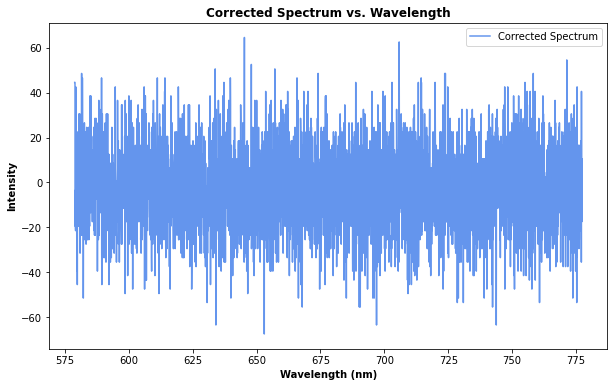

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(wavelengths1, spectrum1, label='Corrected Spectrum', color='cornflowerblue')
plt.xlabel('Wavelength (nm)', fontweight='bold')
plt.ylabel('Intensity', fontweight='bold')
plt.title('Corrected Spectrum vs. Wavelength', fontweight='bold')
plt.legend()
plt.show()

In [42]:
output2 = readSpectra(read_all_serial_numbers()[0], 10000, 1)
wavelengths2, spectrum2 = correct_spectrum(output2)

Device count: 1
Started reading spectra with serial#: HR4P0848
serial#/spectra:  HR4P0848 = 870, 878, 929, 875 

Closing device with serial#: HR4P0848
INFO:  Buffer size returned: 4  


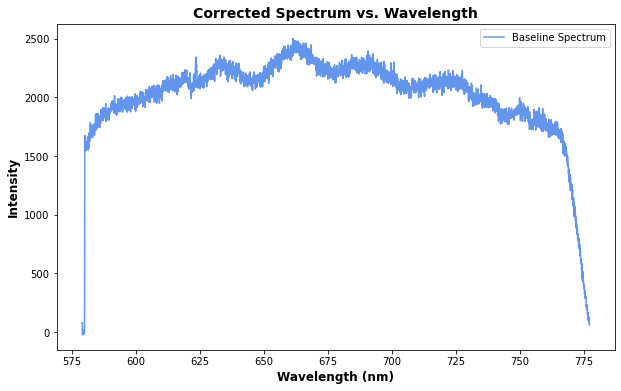

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(wavelengths2, spectrum2, label='Baseline Spectrum', color='cornflowerblue')
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=12)
plt.ylabel('Intensity', fontweight='bold', fontsize=12)
plt.title('Corrected Spectrum vs. Wavelength', fontweight='bold', fontsize=14)
plt.legend()
plt.show()

In [50]:
base_output = readSpectra(read_all_serial_numbers()[0], 10000, 1)
base_wavelengths, base_spectrum = correct_spectrum(base_output)

Device count: 1
Started reading spectra with serial#: HR4P0848
serial#/spectra:  HR4P0848 = 897, 914, 947, 886 

Closing device with serial#: HR4P0848
INFO:  Buffer size returned: 4  


In [51]:
filter_607_output = readSpectra(read_all_serial_numbers()[0], 10000, 1)
base_wavelengths, filter_607_spectrum = correct_spectrum(filter_607_output)

Device count: 1
Started reading spectra with serial#: HR4P0848
serial#/spectra:  HR4P0848 = -8, 1, 0, 4 

Closing device with serial#: HR4P0848
INFO:  Buffer size returned: 4  


In [70]:
normalized = filter_607_spectrum / base_spectrum
smoothed = savgol_filter(normalized, window_length=5, polyorder=2)
percent_transmission = smoothed * 100

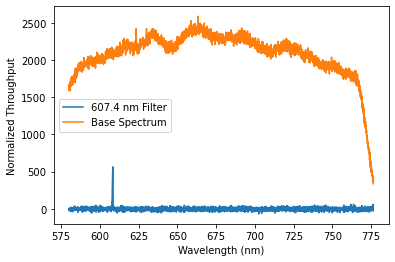

In [80]:
plt.figure()
plt.plot(base_wavelengths[20:-20], filter_607_spectrum[20:-20], label='607.4 nm Filter')
plt.plot(base_wavelengths[20:-20], base_spectrum[20:-20], label='Base Spectrum')
# plt.plot(base_wavelengths[20:-20], percent_transmission[20:-20], label='% Transmission') # exclude the first and last 20 points

plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Throughput')
plt.legend()
plt.show()

In [65]:
specific_wavelength = 607  # example wavelength
specific_wavelength_index = np.argmin(np.abs(base_wavelengths - specific_wavelength))
print(specific_wavelength_index)
print(filter_607_spectrum[specific_wavelength_index])
# throughput_vs_temp = {temp: spectrum[specific_wavelength_index] for temp, spectrum in normalized_spectra.items()}

472
-2.906815078742435


In [69]:
print(max(filter_607_spectrum))
index_of_max_value = np.argmax(filter_607_spectrum)
print(index_of_max_value)
print(base_wavelengths[index_of_max_value])

563.4047055431631
495
608.3274349436476


In [68]:
print(filter_607_spectrum[470:500])

[ -0.90838504 -36.87649127  -2.90681508  -0.90838504  11.08268514
  -2.90681508  17.0785328   39.06506362  19.07719465 -34.8784675
   3.08854525  27.07207044 -16.89516522  21.07587939  13.081278
  11.08268514  85.04556973  81.04681063 103.04102997 169.0385084
 217.04989979 331.11760742 397.1805364  451.24368429 551.38565352
 563.40470554 511.3251742  407.19146594 267.07283943 161.03766724]
